<a href="https://colab.research.google.com/github/simon-mellergaard/datasimon/blob/main/Kaggle%20competitions/introverts-extroverts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

playground_series_s5e7_path = kagglehub.competition_download('playground-series-s5e7')

print('Data source import complete.')


# Making advanced predictions of extrovetrs and introverts

The code is showing the way.

In [ ]:
import pandas as pd
data = pd.read_csv('/kaggle/input/playground-series-s5e7/train.csv', index_col='id')

In [ ]:
data.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
id,,,,,,,,
0,0.0,No,6.0,4.0,No,15.0,5.0,Extrovert
1,1.0,No,7.0,3.0,No,10.0,8.0,Extrovert
2,6.0,Yes,1.0,0.0,NaN,3.0,0.0,Introvert
3,3.0,No,7.0,3.0,No,11.0,5.0,Extrovert
4,1.0,No,4.0,4.0,No,13.0,NaN,Extrovert


The description of the variables are as follows:
* Time_spent_Alone: Hours spent alone daily (0–11).
* Stage_fear: Presence of stage fright (Yes/No).
* Social_event_attendance: Frequency of social events (0–10).
* Going_outside: Frequency of going outside (0–7).
* Drained_after_socializing: Feeling drained after socializing (Yes/No).
* Friends_circle_size: Number of close friends (0–15).
* Post_frequency: Social media post frequency (0–10).
* Personality: Target variable (Extrovert/Introvert).

There are two categorical variables and 6 numeric varialbe. The target variable is binary, so it is a binary classification problem.

In [ ]:
data.describe()

,Time_spent_Alone,Social_event_attendance,Going_outside,Friends_circle_size,Post_frequency
count,17334.000000,17344.000000,17058.000000,17470.000000,17260.000000
mean,3.137764,5.265106,4.044319,7.996737,4.982097
std,3.003786,2.753359,2.062580,4.223484,2.879139
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,3.000000,3.000000,5.000000,3.000000
50%,2.000000,5.000000,4.000000,8.000000,5.000000
75%,4.000000,8.000000,6.000000,12.000000,7.000000
max,11.000000,10.000000,7.000000,15.000000,10.000000


In [ ]:
data.dtypes

Time_spent_Alone             float64
Stage_fear                    object
Social_event_attendance      float64
Going_outside                float64
Drained_after_socializing     object
Friends_circle_size          float64
Post_frequency               float64
Personality                   object
dtype: object

array([[<Axes: title={'center': 'Time_spent_Alone'}>,
        <Axes: title={'center': 'Social_event_attendance'}>],
       [<Axes: title={'center': 'Going_outside'}>,
        <Axes: title={'center': 'Friends_circle_size'}>],
       [<Axes: title={'center': 'Post_frequency'}>, <Axes: >]],
      dtype=object)

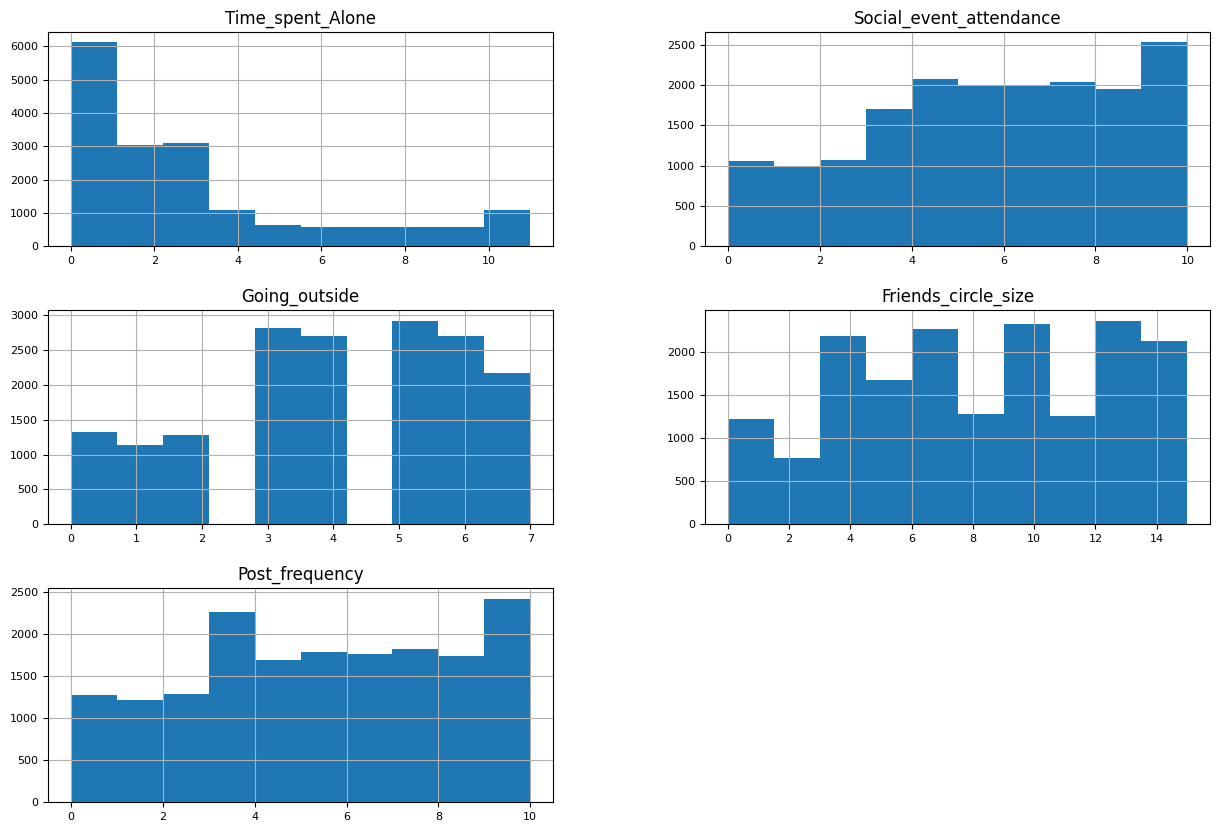

In [ ]:
import matplotlib as plt
import seaborn as sns

data.hist(figsize=(15, 10), xlabelsize=8, ylabelsize=8)

The data looks to be pretty uniformly distributed, however time spend alone tend to be right skewed.

In [ ]:
data = data.replace({True: 1, False: 0})

/tmp/ipykernel_36/3013327828.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data = data.replace({True: 1, False: 0})


In [ ]:
data = data.drop(columns=['Personality'])

/tmp/ipykernel_36/529715823.py:9: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1, 3, plot_count + 1)  # Adjust subplot position


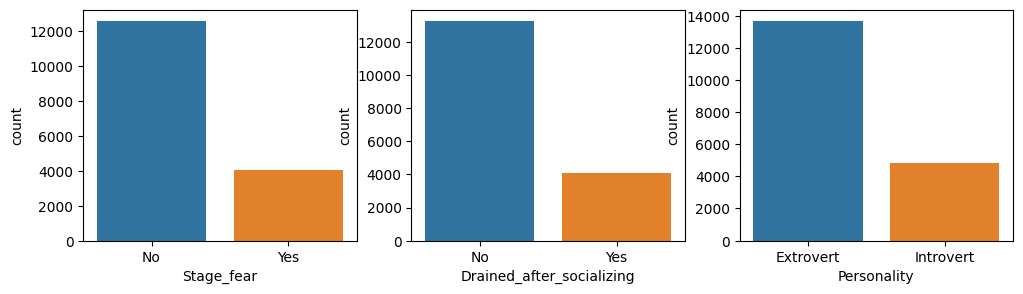

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 3))
plt.title("Categoraical variables")
plt.axis("off")
plot_count = 0  # Initialize a counter for displayed images
categorical_variables = ['Stage_fear', 'Drained_after_socializing', 'Personality']

for var in categorical_variables:
    ax = plt.subplot(1, 3, plot_count + 1)  # Adjust subplot position
    sns.countplot(data, x = var)
    plot_count += 1  # Increment the counter
plt.show()

All distributions look moderately skewed.

/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


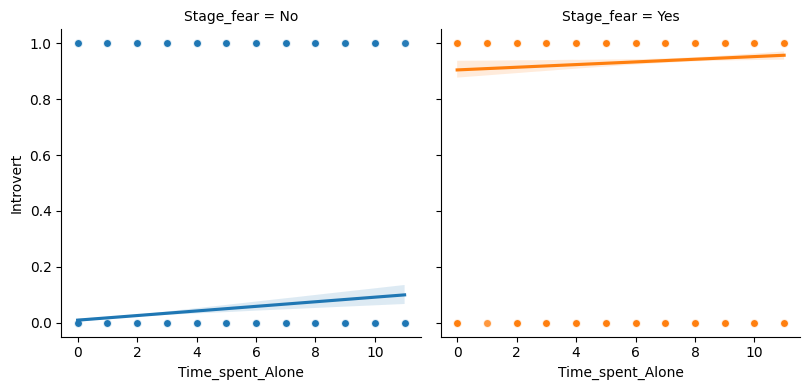

In [ ]:
sns.lmplot(
    x='Time_spent_Alone', y="Introvert", hue="Stage_fear", col="Stage_fear",
    data=data, scatter_kws={"edgecolor": 'w'}, col_wrap=3, height=4,
);

# Preparing data

The data is split into a training and testing set

In [ ]:
from sklearn.model_selection import train_test_split
# Making X and y variables
X = data.copy()
y = X.pop('Introvert')

train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 0)